# Spooky Author Identification: Fine-tuning models from scikit-learn and XGBoost libraries

**Jay Manvirk (Ivan Loginov)**<br/>
University of Colorado, Boulder<br/>
jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per author](#chapter_4_2)
    - 4.3 [Word frequencies per author](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Text cleaning](#chapter_5_1)
    - 5.2 [TF-IDF vectorization](#chapter_5_2)
6. [Model architecture](#chapter_6)
    - 6.1 [Logistic Regression](#chapter_6_1)
    - 6.2 [Random Forest](#chapter_6_2)
    - 6.3 [Multinomial Naive Bayes](#chapter_6_3)
    - 6.4 [SVM](#chapter_6_4)
    - 6.5 [XGBoost](#chapter_6_5)
7. [Model results](#chapter_7)
    - 7.1 [Logistic Regression](#chapter_7_1)
    - 7.2 [Random Forest](#chapter_7_2)
    - 7.3 [Multinomial Naive Bayes](#chapter_7_3)
    - 7.4 [SVM](#chapter_7_4)
    - 7.5 [XGBoost](#chapter_7_5)
    - 7.6 [Model results comparison](#chapter_7_6)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

TODO

# 2. Introduction <a class="anchor" id="chapter_2"></a>

TODO

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [2]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ProcessPoolExecutor

# Model architecture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [3]:
# Print list of files and directories in folder
list_l = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        list_l.append(os.path.join(dirname, filename))
list_l

['/kaggle/input/spooky-author-identification/train.zip',
 '/kaggle/input/spooky-author-identification/test.zip',
 '/kaggle/input/spooky-author-identification/sample_submission.zip']

In [4]:
# Set datasets
train_data = pd.read_csv(list_l[0])
test_data = pd.read_csv(list_l[1])
sample_data = pd.read_csv(list_l[2])

In [5]:
# Cleaning
del list_l

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

The dataset includes 3 unique authors (categories):
* EAP, Edgar Allan Poe
* HPL, Howard Phillips Lovecraft
* MWS, Mary Wollstonecraft Shelley

The memory usage of datasets is measured in kilobytes. The approximate numbers are:
* training data: 459 kB
* testing data: 131 kB
* sample data: 262.4 kB

In [6]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [7]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

2. Data shape: (19579, 3)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [8]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
3  id27757  While I was thinking how I should possibly man...
4  id04081  I am not sure to what limit his knowledge may ...

2. Data shape: (8392, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB


In [9]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
        id       EAP       HPL       MWS
0  id02310  0.403494  0.287808  0.308698
1  id24541  0.403494  0.287808  0.308698
2  id00134  0.403494  0.287808  0.308698
3  id27757  0.403494  0.287808  0.308698
4  id04081  0.403494  0.287808  0.308698

2. Data shape: (8392, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8392 non-null   object 
 1   EAP     8392 non-null   float64
 2   HPL     8392 non-null   float64
 3   MWS     8392 non-null   float64
dtypes: float64(3), object(1)
memory usage: 262.4+ KB


In [10]:
# Cleaning
del print_short_summary

## 4.2 Number of records per author <a class="anchor" id="chapter_4_2"></a>

The dataset is slightly imbalanced in terms of number of texts per author. However this dataset doesn't need additional down/up-sampling for 2 mjor reasons:
1. Information loss when downsampling: removed samples can contain unique author's style which model wouldn't be able to catch
2. Overfitting when upsampling: with added replicated samples model starts memorizing the duplicated examples instead of learning the underlying patterns

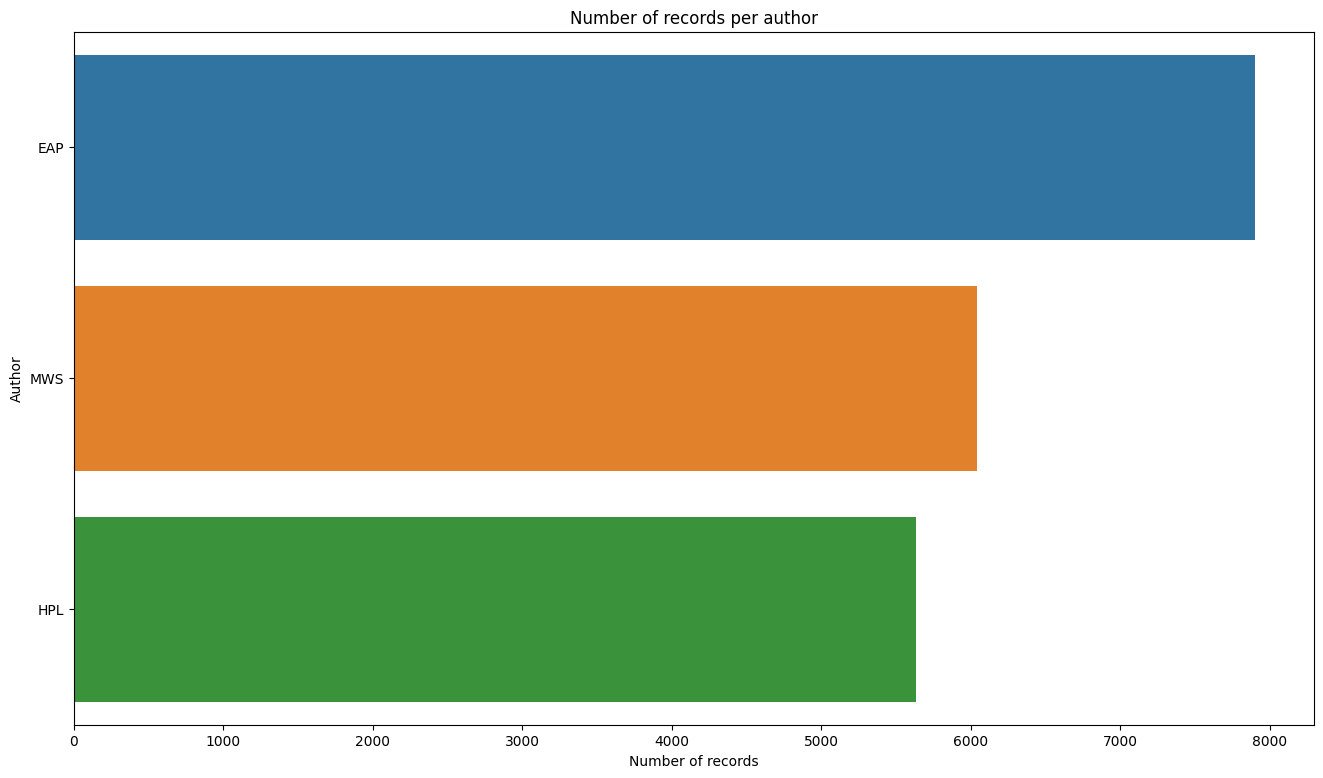

In [11]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['author'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Author')
plt.title('Number of records per author')
plt.show()

In [12]:
# Cleaning
del tmp

## 4.3 Word frequencies per author <a class="anchor" id="chapter_4_3"></a>

Form the first set of charts it's clear that prepositions, articles and pronouns dominate in the frequency. This can hinder following models abilities to correctly clsaasify authors, since their texts share the same distribution of short word usage. Given that we can cosider these words as a noise. By removing this noise we can get closer to understand specifics of word usage of each author. We will address this problem in the following sections.

In [13]:
def plot_word_dist_author(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per author
    Args:
        labels: list of authors
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 1 row and n columns
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))
    
    # Plot word count per author in the respective rows
    for i in range(n):
        col = i % n
        indexes = train_data['author'] == labels[i]
        w = train_data['text'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()

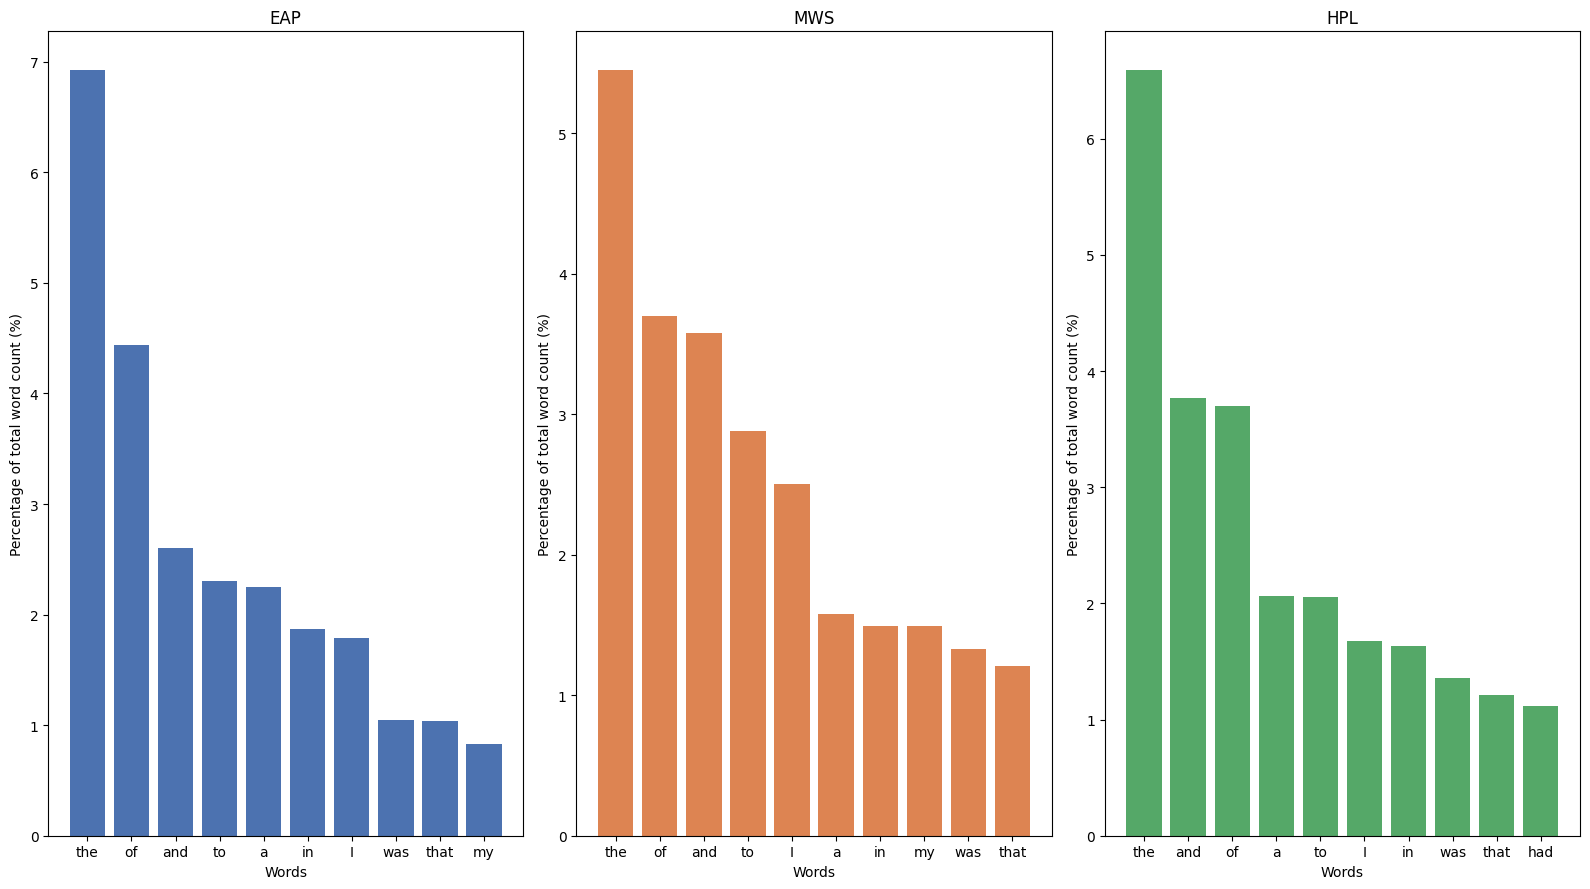

In [16]:
# Plot word frequencies by author
plot_word_dist_author(['EAP', 'MWS', 'HPL'])

In [17]:
# Cleaning
del labels, plot_word_dist_author

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Text cleaning <a class="anchor" id="chapter_5_1"></a>

In order

In [23]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b|\d+|[.,!?()-:;]')

# Set english stopwords such as "the", "of", "and", "to" etc.
stop_words = set(stopwords.words('english'))

In [20]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and digits.
    Everything is in the lower case register.
    Args:
        text (str): text of an article
    Returns:
        text (str): cleand text
    """
    # Convert to lowercase and remove digits, single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]

    # Join the words back into a string
    text = ' '.join(lemmas)
    
    return text

def get_clean_text(texts):
    """
    Return cleaned text. Execution in parallel.
    Args:
        texts: numpy array of string elements
    Returns:
        clean_texts: numpy array of cleaned string elements
    """
    # Set up parallel tasks processing 
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
        
    return np.array(clean_texts)

In [24]:
# Get cleaned train and test texts
train_clean_data = get_clean_text(train_data['text'].values)
test_clean_data = get_clean_text(test_data['text'].values)

In [25]:
# Print an example of the cleaned text
train_clean_data[0]

'process however afford mean ascertain dimension dungeon   might make circuit return point whence   set without aware fact perfectly uniform seem wall'

In [19]:
# Cleaning
del get_clean_text, get_processed_text

## 5.2 TF-IDF vectorization <a class="anchor" id="chapter_5_2"></a>

When the TfidfVectorizer is applied to raw text, it converts the text data into a matrix of TF-IDF features. Specifically, the output is a sparse matrix representing the TF-IDF weights of the words in the input text. Each row in the matrix corresponds to a document (or text sample), and each column corresponds to a unique word or feature in the entire corpus.

* sublinear_tf = True: this scaling often produces better results
* ngram_range = (1, 2): with both unigrams and bigrams TF-IDF can capture more context and potentially improve the model's understanding of the text

In [26]:
# Create vectorizer to convert plain text into feature matrix
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_clean_data)

In [27]:
# Set training and testing data for the following models
X_train = tfidf_vect.transform(train_clean_data)
X_test = tfidf_vect.transform(test_clean_data)

y_train = train_data['author'].values

In [24]:
del vectorizer, train_data, test_data, train_clean_data, test_clean_data

# 6. Model architecture <a class="anchor" id="chapter_6"></a>

TODO

## 6.1 Logistic Regression <a class="anchor" id="chapter_6_1"></a>

* C: inverse of regularization strength. Smaller values specify stronger regularization.

In [25]:
# Set config for GridSearchCV
config_logreg = {
    'model': LogisticRegression()
    , 'name': 'Log Reg'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'C': [0.5, 1.0, 1.5]
        , 'solver': ['newton-cg', 'saga', 'lbfgs']
    }
}

## 6.2 Random Forest <a class="anchor" id="chapter_6_2"></a>

TODO

In [26]:
# Set config for GridSearchCV
config_rf = {
    'model': RandomForestClassifier()
    , 'name': 'Random Forest'
    , 'param_grid':
    {
        'n_estimators': [50, 100, 150]
        , 'max_depth': [None, 10, 20]
    }
}

## 6.3 Multinomial Naive Bayes <a class="anchor" id="chapter_6_3"></a>

TODO

In [27]:
# Set config for GridSearchCV
config_nb = {
    'model': MultinomialNB()
    , 'name': 'Mult NB'
    , 'param_grid':
    {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    }
}

## 6.4 SVM <a class="anchor" id="chapter_6_4"></a>

TODO

In [28]:
# Set config for GridSearchCV
config_svm = {
    'model': SVC()
    , 'name': 'SVM'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'C': [0.5, 1.0, 1.5]
        , 'kernel': ['poly','rbf', 'sigmoid']
    }
}

## 6.5 XGBoost <a class="anchor" id="chapter_6_5"></a>

TODO

In [29]:
# Set config for GridSearchCV
config_xgb = {
    'model': xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
    , 'name': 'XGBoost'
    , 'param_grid':
    {
        'eta': [0.01, 0.1, 0.3]
        , 'max_depth': [3, 5, 7]
        , 'subsample': [0.5, 0.8, 1]
    }
}

# 7. Model results <a class="anchor" id="chapter_7"></a>

In [31]:
def get_grid(config_model, X_train, y_train):
    """
    Return a table of results from selected models and their parameters.
    
    Args:
        config_model (dict): dictionary of model's parameters
        X_train (ndarray): data to train
        y_train (ndarray): data labels
    Returns:
        dict: a dictionary with the results from training via GridSeachCV
    """
    grid = GridSearchCV(config_model['model']
                        , config_model['param_grid']
                        , return_train_score = True
                        , cv = 5)

    # Fit object to training data
    grid = grid.fit(X_train, y_train)

    # Add new key 'model' for later depiction in a table comparison
    n = len(grid.cv_results_['params'])
    grid.cv_results_['model'] = [model_params[i]['name']]*n
        

    return grid.cv_results_

def get_results_table(results):
    """
    Return table of model results sorted by logloss and runtime.
    
    Args:
        results (dict): dictionary of model results
    Returns:
        DataFrame: dataframe with selected columns sorted by logloss and runtime
    """
    columns = ['model','params','mean_fit_time','mean_score_time','mean_train_score', 'mean_test_score']
    df = results.copy()[columns]
    df['mean_runtime'] = df['mean_fit_time'] + df['mean_score_time']
    df = df[['model','params','mean_runtime','mean_train_score','mean_test_score']]
    df = df.sort_values(by=['mean_test_score','mean_runtime'], ascending=[False,True])
    
    return df

## 7.1 Logistic Regression <a class="anchor" id="chapter_7_1"></a>

In [ ]:
grid_logreg = get_grid(config_logreg)
table_logreg = get_dataframe(grid_logreg)

In [ ]:
table_logreg

## 7.2 Random Forest <a class="anchor" id="chapter_7_2"></a>

## 7.3 Multinomial Naive Bayes <a class="anchor" id="chapter_7_3"></a>

## 7.4 SVM <a class="anchor" id="chapter_7_4"></a>

## 7.5 XGBoost <a class="anchor" id="chapter_7_5"></a>

## 7.6 Model results comparison <a class="anchor" id="chapter_7_6"></a>

TODO

In [ ]:
# Print table results comparison
table = pd.concat([table_logreg
                   , table_rf
                   , table_nb
                   , table_svm
                   , table_xgb])

pd.DataFrame(table).sort_values(by = ['test_logloss'
                                      ,'runtime (sec)']
                                , ascending = [False, True])

In [ ]:
# Cleaning
del table, train_dataset, test_dataset, train_data
del get_results_table, get_grid

# 8. Submission results <a class="anchor" id="chapter_8"></a>

#### Public score: ???

In [ ]:
# Cleaning
del sample_data

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

TODO

# 10. References <a class="anchor" id="chapter_10"></a>

* BBC News Classification: Matrix Factorization vs Supervised Learning<br/>
https://www.kaggle.com/code/jaymanvirk/matrix-factorization-nmf-vs-supervised-learning
* Scikit-learn API Reference<br/>
https://scikit-learn.org/stable/modules/classes.html